In [2]:
# Imports
import scripts.io as io
import scripts.util as util
import scripts.NN as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

cmap=plt.cm.get_cmap(plt.cm.viridis,143)

## Part 1: Autoencoder implementation

1) Implement a feed-forward, neural network with standard sigmoidal units. Your
implementation should accept a vector as input, be able to adjust network weights by
backpropagation, and report the average loss per epoch. It should also allow for
variation in the size of input layer, hidden layers, and output layer. We expect that you
will be able to produce fast enough code to be of use in the learning task at hand.

a. To confirm that your implementation functions correctly, demonstrate its ability to
correctly solve the 8 x 3 x 8 autoencoder task. Specifically, set up an
autoencoder network consisting of an input layer (8 nodes), a hidden layer (3
nodes), and an output layer (8 nodes), all with sigmoidal units.

Text(0, 0.5, 'Loss (Sum of Squares)')

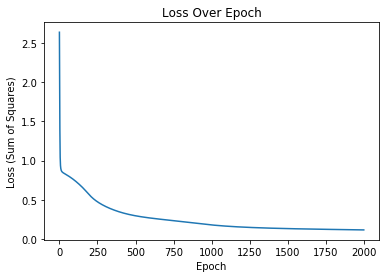

In [3]:
# Model Training #

n_train = 1000
n_test = 1000

# Define network dimensions
dim = [8, 3, 8]

# Define training data
x = util.gen_label_array((dim[0], n_train))

# Define the number of epochs and learning rate for model training
n_epochs = 2000
learning_rate = 2e-3

# Create and fit model
net =nn.NeuralNetwork(dim)
net.fit(x, x, n_epochs, learning_rate)

# Plot loss over range of epochs
plt.plot(net.loss_list)
plt.title('Loss Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (Sum of Squares)')

In [4]:
# Model Testing #

# Define testing data and labels
x_ = util.gen_label_array((dim[0], n_test))

# Make prediction on testing data
yfin = net.predict(x_, x_)

Text(0.08, 0.5, 'Label Value')

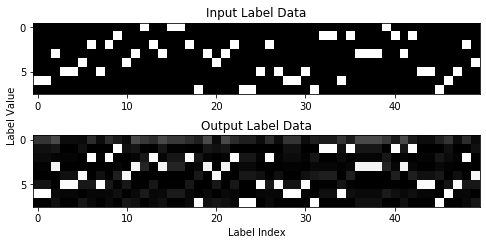

In [5]:
# Let's visually investigate the model accuracy

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 3.8))

ax1.imshow(x_[:,0:50], cmap='gray') # Plot the input data
ax1.set_title('Input Label Data')
ax2.imshow(yfin[:,0:50], cmap='gray') # Plot the output data
ax2.set_title('Output Label Data')
ax2.set_xlabel('Label Index')
fig.text(0.08, 0.5, 'Label Value', va='center', rotation='vertical')

In [6]:
# Determine accuracy of model

count_correct = []

# Loop through testing results
for i in range(0, n_test):
    call = yfin[:,i:i+1].argmax()  # Find index of maximum value in output layer
    label = x_[:,i:i+1].argmax()
    if call == label:  # Compare output layer to known class
        count_correct.append(1)
    else:
        count_correct.append(0)
        
# Calculate Accuracy
acc = np.sum(count_correct)/len(count_correct) * 100
print(f'Model Accuracy: {acc:.2f}%')

Model Accuracy: 100.00%


As expected, the autoencoder has perfect accuracy. Visualizing the model results shows the noise present in the model output, which is expected given that we compress the input data from eight to three in the neural network.

# Part 2: Adapt for classification, and develop training regime

2) Set up a procedure to encode DNA sequences (Rap1 binding sites) as input for your
neural network. Consider how your encoding strategy may influence your network
predictions.

a. Describe your process of encoding your training DNA sequences into input
vectors in detail. Include a description of how you think the representation might
affect your network’s predictions.

In [11]:
# Import DNA sequences

pos = io.txt2str('data/rap1-lieb-positives.txt')
neg = io.fa2str('data/yeast-upstream-1k-negative.fa')

In [12]:
# One-hot encode the sequences

pos_array = np.hstack(util.one_hot_dna(pos, 17))
neg_array = np.hstack(util.one_hot_dna(neg, 1000))

Individual DNA sequence strings are read in like so:

In [13]:
pos[0]

'ACATCCGTGCACCTCCG'

The sequence is then one-hot encoded. This encoding scheme converts the the nucleotide categories: 'A', 'T', 'G', and 'C', into numeric dummy variables: [0,0,0,1], [0,0,1,0], [0,1,0,0], and [1,0,0,0], which can be input into the neural network.

Following the encoding step, you have the option of either concatenating your encoded vectors into a 1D array of size (n*4, 1) or into a 2D array or size (n, 4). ... ... ... An encoded example of the sequence above is shown below.

In [14]:
pos_array[:,0]

array([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.])

3) Design a training regime that will use both positive and negative training data to train
your predictive model. Note that if you use a naive scheme here, which overweights
the negative data, your system will probably not converge (it will just call everything a
non-Rap1 site).

a. Describe your training regime. How was your training regime designed so
as to prevent the negative training data from overwhelming the positive
training data?

In [15]:
# Split data into training and testing data

# Split positive data
pos_train_array, pos_test_array = util.train_test_split(pos_array, 80)

# As there are so many negative sequence examples, let's take only a portion 
# of the negative sequence data. Let's also trim the 1kb sequences down 
# to 17bp. Both of these selection will be done randomly.
samp_len = 300
tot_len = neg_array.shape[1]

n = random.randint(0, tot_len-samp_len)
neg_array_trim = neg_array[:,n:n+samp_len]
neg_array_sample = util.sample_array(neg_array_trim, 17, 4)

neg_train_array, neg_test_array = util.train_test_split(neg_array_sample, 180)

For my training regime I randomly split the positive and negative sets into training and testing sets. For the positive example this resulted in ~60% training ~40% testing (80, 57). For the negative set, I randomly selected 17bp sequences from the given 1kb sequences, and then used only a small portion ~10% of the overall testing data in order to avoid overfitting my model on negative training data. The negative training data was then split to ~60% training ~40% testing (180, 120).

In [16]:
# Create training and testing arrays

train_array = np.concatenate((pos_train_array, neg_train_array), axis=1)
test_array = np.concatenate((pos_test_array, neg_test_array), axis=1)

train_shuffle = np.random.permutation(train_array.shape[1])
test_shuffle = np.random.permutation(test_array.shape[1])

train_array = train_array[:, train_shuffle]
test_array = test_array[:, test_shuffle]

In [17]:
# Generate training and testing label arrays

trp, trn = pos_train_array.shape[1], neg_train_array.shape[1]
tep, ten = pos_test_array.shape[1], neg_test_array.shape[1]

train_labels = np.array([[1]*trp + [0]*trn])
test_labels = np.array([[1]*tep + [0]*ten])

train_labels = train_labels[:, train_shuffle]
test_labels = test_labels[:, test_shuffle]

4) Modify your implementation to take as input positive and negative examples of
Rap1 binding sites (using your encoding from Q2) and produce an output
probability between [0 - 1.0] indicating classification as a binding site (1.0) or not
(0.0) . Select a network architecture, and train your network using the training
regime you described in Q3 on all the data.

a. Provide an example of the input and output for one true positive sequence
and one true negative sequence.

b. Describe your network architecture, and the results of your training. How did
your network perform in terms of minimizing error?

c. What was your stop criterion for convergence in your learned parameters? How
did you decide this?

Text(0, 0.5, 'Loss (Sum of Squares)')

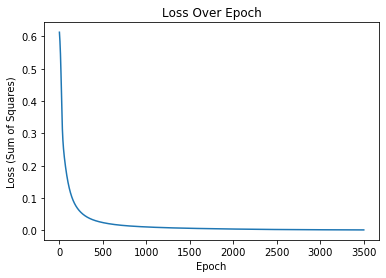

In [18]:
# Model Training #

# Define training data and labels
x = train_array
y = train_labels

# Define the number of epochs and learning rate for model training
n_epochs = 3500
learning_rate = 2e-3

# Create and fit model
dim = [68, 10, 1]
net = nn.NeuralNetwork(dim)
net.fit(x, y, n_epochs, learning_rate)

# Plot loss over range of epochs
plt.plot(net.loss_list)
plt.title('Loss Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (Sum of Squares)')

In [19]:
# Model Testing #

# Define testing data and labels
x_ = test_array
y_ = test_labels

# Make prediction on testing data
yfin = net.predict(x_, y_)

In [20]:
print('\n True Positive Input Array:', x_[:,0], 
      '\n True Positive Output:', yfin[:,0][0], 
      '\n\n True Negative Input Array:', x_[:,-1], 
      '\n True Negative Output:', yfin[:,-1][0])


 True Positive Input Array: [1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.] 
 True Positive Output: 3.854340717872207e-05 

 True Negative Input Array: [1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.] 
 True Negative Output: 0.8919338597120315


In [21]:
# Determine accuracy of model

tot = y_.shape[1]

res = np.around(yfin)
mis = np.sum(np.abs(y_ - res))

# Calculate accuracy
acc = ((tot-mis)/tot) * 100
print(f'Model Accuracy: {acc:.2f}%')

Model Accuracy: 98.31%


The network has three layer with the following dimmensions:

68 : 10 : 1

Error miminimalization during training can be seen above, under the model training cell. Over 2000 epochs with a learning rate of .002, loss decreased approximately exponentially from ~0.12 to ~0.0015.

My stop criteria was ... ... ...

## Part 3: Cross-validation

5) Evaluate your model’s classification performance via k-fold cross validation.

a. How can you use k-fold cross validation to determine your model’s performance?

b. Given the size of your dataset, positive and negative examples, how would you select a value for k?

c. Using the selected value of k, determine a relevant metric of performance for each fold. Describe how your model performed under cross validation.

In [22]:
# Let's recombine our arrays from earlier so they can be split k-times

input_array = np.concatenate((train_array, test_array), axis=1)
output_array = np.concatenate((train_labels, test_labels), axis=1)

In [23]:
# 
k = 10

shuffle = np.random.permutation(input_array.shape[1])
split_shuffle = list(util.split(shuffle, k))

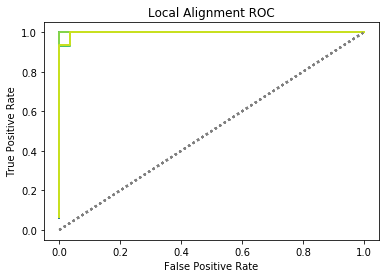

<Figure size 360x360 with 0 Axes>

Mean AUROC = 0.999


In [25]:
n_epochs = 1000
learning_rate = 2e-3
dim = [68, 10, 1]

auc_list = []

for n, test in enumerate(split_shuffle):
    
    train_list = split_shuffle.copy()
    del train_list[n]
    train = np.hstack(train_list)
    
    x = input_array[:, train]
    y = output_array[:, train]
    
    x_ = input_array[:, test]
    y_ = output_array[:, test]
    
    net = nn.NeuralNetwork(dim)
    net.fit(x, y, n_epochs, learning_rate)
    
    # Make prediction on testing data
    yfin = net.predict(x_, y_)
    
    pred_list = util.pred_gen(yfin[0])
    tpr, fpr = util.pr_calc(y_[0], pred_list)
    auc_list.append(auc(fpr, tpr))
    
    plt.plot(fpr, tpr, c=cmap(26*n), lw=2)
    plt.plot([0, 1], [0, 1], color='C7', lw=2, linestyle=':')
    plt.title('Local Alignment ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure(figsize=[5,5])
plt.show()

print(f'Mean AUROC = {np.mean(auc_list):.3f}')

## Part 4: Extension

## Part 5: Evaluate your network on the final set

6) To provide an objective measure of your neural network's ability to classify binding
sites, a test dataset has been provided (rap1-lieb-test.txt). There are no class labels on
these sequences. Your goal is to maximize the separation in scores for the true Rap1
binding sites as compared with the non-sites.

a. Select a final model (encoding, architecture, training regime). This can be the same as your model in Part 3, Part 4, or something completely different.

b. Train your final model on the entire training dataset. Run the trained system on the test dataset. For each sequence, output the sequence and its output value from the network, separated by a tab, as follows:

ACATCCGTGCACCATTT 0.927

AAAAAAACGCAACTAAT 0.123